In [26]:
!nvidia-smi

Tue Dec  3 14:20:34 2024       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.120                Driver Version: 550.120        CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA GeForce RTX 3060        Off |   00000000:01:00.0 Off |                  N/A |
|  0%   45C    P8             21W /  170W |     666MiB /  12288MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [27]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc")

print("Path to dataset files:", path)

Path to dataset files: /home/andrew-root/.cache/kagglehub/datasets/samiraalipour/genomics-of-drug-sensitivity-in-cancer-gdsc/versions/2


In [28]:
import warnings 
warnings.filterwarnings('ignore')

In [29]:
import torch
import torch.nn as nn
from sklearn.metrics import mean_squared_error, mean_absolute_error
import numpy as np
import matplotlib.pyplot as plt
from utils import DataLoader, MLP_Tuner, CNNTransformer_Tuner

device = 'cuda' if torch.cuda.is_available() else 'cpu'

ImportError: cannot import name 'MLP_Tuner' from 'utils' (/home/andrew-root/cancer_kaggle/utils.py)

In [ ]:
dataloader = DataLoader(path, '/GDSC_DATASET.csv',
                        path, '/Compounds-annotation.csv',
                        path, '/GDSC2-dataset.csv',
                        path, '/Cell_Lines_Details.xlsx')
dataloader.load_data()
dataloader.preprocess_data()
dataloader.define_features_and_target()

TypeError: DataLoader.__init__() takes 5 positional arguments but 9 were given

In [ ]:
# Convert the data to PyTorch tensors
X_train_tensor, y_train_tensor, X_test_tensor, y_test_tensor, input_dim = dataloader.Convert_to_tensors()

# Initialize the tuner
MLP_tuner = MLP_Tuner(input_dim)

# Tune hyperparameters
best_model = MLP_tuner.tune_hyperparameters(X_train_tensor, y_train_tensor)

/home/andrew-root/miniconda3/envs/assignment/lib/python3.11/site-packages/skorch/net.py:2231: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  cuda_attrs = torch.load(f, **load

Best Parameters: {'lr': 0.0001, 'module__hidden_dims': [256, 128, 64], 'optimizer__weight_decay': 0.0001}
Best Score: -7.7621690432230634


In [21]:
# Evaluate the best model on the test set
train_losses = []
val_losses = []

for epoch in range(best_model.max_epochs):
    best_model.partial_fit(X_train_tensor, y_train_tensor)
    train_pred = best_model.predict(X_train_tensor).squeeze()
    val_pred = best_model.predict(X_test_tensor).squeeze()
    train_loss = mean_squared_error(y_train_tensor.numpy(), train_pred)
    val_loss = mean_squared_error(y_test_tensor.numpy(), val_pred)
    train_losses.append(train_loss)
    val_losses.append(val_loss)

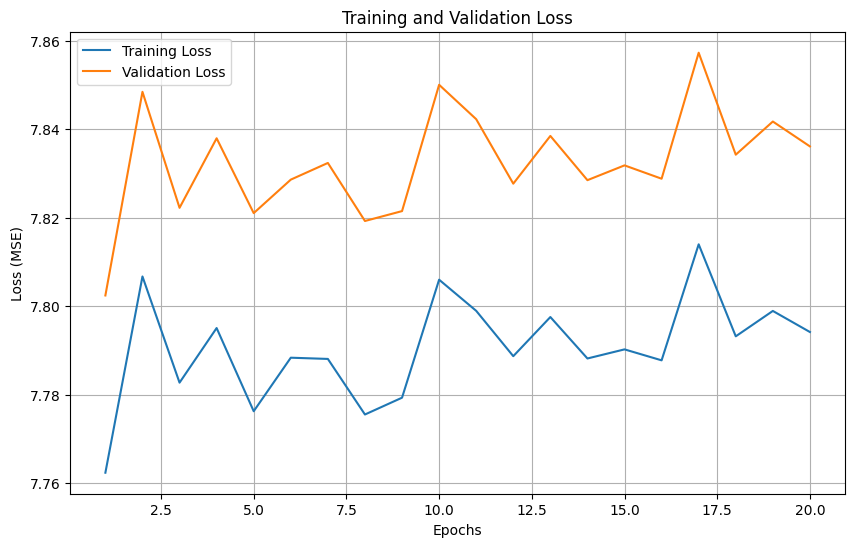

In [22]:
# Plot training and validation loss to check for overfitting
plt.figure(figsize=(10, 6))
plt.plot(range(1, best_model.max_epochs + 1), train_losses, label='Training Loss')
plt.plot(range(1, best_model.max_epochs + 1), val_losses, label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss (MSE)')
plt.title('Training and Validation Loss')
plt.legend()
plt.grid(True)
plt.show()

In [23]:
# Evaluate the best model on the test set
# best_model.eval()
with torch.no_grad():
    predictions = best_model.predict(X_test_tensor).squeeze()
    predictions = torch.tensor(predictions)    
    
    # Calculate RMSE, MAE, and MSE
    rmse = torch.sqrt(nn.MSELoss()(predictions, y_test_tensor)).item()
    mae = mean_absolute_error(y_test_tensor.numpy(), predictions.numpy())
    mse = mean_squared_error(y_test_tensor.numpy(), predictions.numpy())
    
    print(f"Test RMSE: {rmse:.4f}")
    print(f"Test MAE: {mae:.4f}")
    print(f"Test MSE: {mse:.4f}")

Test RMSE: 2.7993
Test MAE: 2.1281
Test MSE: 7.8361


## DL

In [ ]:
# Initialize the tuner
CNNTransformer_tuner = CNNTransformer_Tuner(input_dim)

# Tune hyperparameters
best_model = CNNTransformer_tuner.tune_hyperparameters(X_train_tensor, y_train_tensor)